## Fixed-prompt Cash Donations Exploratory Analysis 
**Purpose**   
To visualise the relationships among the data and inform the kinds of data transformations that you'll need for machine learning models. 

This version analyses the 2017 June Cash appeal mailing, which included active and lapsed segments and each with a variable and fixed prompt test.  
I will repeat the earlier analysis of lapsed supporters to see if active supporters behave in the same way/ the same relationships are demonstrated.

<img src="June Cash Responses.png">

**Responses ** (as at 30/08/2017)  
The active group respond well to the fixed £20 ask, the response rate is 8.3%, 0.5% higher than the variable group. However, the "Income Per Donor Approached" is 4p lower per supporter due to a lower average gift. The lapsed segment perform similarly in terms of response, and the IPDA is also lower for the fixed prompt.  

The purpose of the fixed prompt was not to see if it could generate more income, but to provide a sample of supporters which have the same influence, rather than a variable rate which prevents you from understanding the relationship because donated amount and other characteristics.  

In addition, this test tells us that what you ask for influences what you get and how many supporters respond.  It also confirms that the current strategy performs better than a fixed ask, in terms of IPDA.

In [1]:
#Loading packages 
from sklearn import datasets, neighbors, metrics
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
%matplotlib inline 

## Importing data  
Data imported directly from unicef-dwh SQL server the table created by the following script;  
\\unicef-data\Data\Data\Fund\Public\Internal insight\Analysis\2017 Projects\K037 Cash Prompt Optimisation\3 Working files\Cash mailings v2.sql

In [2]:
## I ran "pip install pypyodbc" from the command line 
import pypyodbc , pandas as pd 
connection = pypyodbc.connect('Driver={SQL Server};'
                              'Server=unicef-dwh;'
                              'Database = analystdata;'
                              'Trusted_Connection=yes;')
cursor = connection.cursor()

In [3]:
## just keeping those that responded to a fixed ask for the first stage of modelling 
SQLCommand = ("SELECT * FROM analystdata.dbo.K037_cashTesting_v2 where responded=1 and activitycode in('KA64','KA63')") 
cursor.execute(SQLCommand) 

columns = [column[0] for column in cursor.description]
data= cursor.fetchall()

for i in range(0,len(data)):
    data[i]=tuple(data[i])
    
df_orig = pd.DataFrame(data, columns = columns)
connection.close()

In [15]:
df_orig.columns
# df_orig['audienceprofile2016'].drop_duplicates()

Index(['activitycode', 'campaignname', 'nlcode', 'lalmsreferencecode',
       'prompttype', 'audience', 'value', 'fixedprompt', 'idcontact',
       'dateprinted', 'segmentreference', 'postcode', 'mosaic',
       'audienceprofile2016', 'responded', 'donatedamount', 'giftaid',
       'variableprompt1', 'variableprompt2', 'variableprompt3',
       'lastdonationemer', 'lastoneoffdate', 'oneoffavgdonatedlast24m',
       'oneoffdonationsl24m', 'everpledgeflag', 'alldonationsavgl24m',
       'firstdonationdate', 'lastdonationdate', 'oneoffltv', 'allltv',
       'lastoneoffamount', 'lastoneoffga', 'lifetimedonations',
       'monthssincelastoneoff', 'monthssincefirstdonation',
       'monthssincelastdonation'],
      dtype='object')

In [16]:
##Renaming and dropping features that wouldn't be a predictor (eg personal details, unique ID's) 
#df = df.loc[df['responded'] == 1]  Applied this in SQL above.

features = ['activitycode', 'prompttype', 'mosaic', #'postcode', 'responded', 'dateprinted','audience',
            'audienceprofile2016', 'donatedamount','fixedprompt', 'variableprompt1', 'giftaid',# 'variableprompt2','variableprompt3', 
            'lastdonationemer',  'oneoffavgdonatedlast24m','oneoffdonationsl24m', 
            'everpledgeflag', 'alldonationsavgl24m',#'firstdonationdate', 'lastdonationdate', 'lastoneoffdate',
            'oneoffltv', 'allltv','lastoneoffamount', 'lastoneoffga', 'lifetimedonations', 'monthssincelastoneoff',
            'monthssincefirstdonation', 'monthssincelastdonation']
df = df_orig[features]

df['donationgiftaid_flag'] = df.giftaid.apply(lambda x: 1 if x > 0 else 0) 

print(df.shape)

## How many nulls are there? What are the datatypes?
for x in df.columns.values:
    print (x,# print variable name 
           ', Type:', df[x].dtypes, #print data type 
           ', Nulls:', df[x].isnull().sum()) # print number of nulls 


(1758, 22)
activitycode , Type: object , Nulls: 0
prompttype , Type: object , Nulls: 0
mosaic , Type: object , Nulls: 24
audienceprofile2016 , Type: object , Nulls: 17
donatedamount , Type: object , Nulls: 0
fixedprompt , Type: object , Nulls: 1573
variableprompt1 , Type: object , Nulls: 0
giftaid , Type: object , Nulls: 0
lastdonationemer , Type: int64 , Nulls: 0
oneoffavgdonatedlast24m , Type: object , Nulls: 0
oneoffdonationsl24m , Type: int64 , Nulls: 0
everpledgeflag , Type: int64 , Nulls: 0
alldonationsavgl24m , Type: object , Nulls: 0
oneoffltv , Type: object , Nulls: 0
allltv , Type: object , Nulls: 0
lastoneoffamount , Type: object , Nulls: 0
lastoneoffga , Type: int64 , Nulls: 0
lifetimedonations , Type: int64 , Nulls: 0
monthssincelastoneoff , Type: int64 , Nulls: 0
monthssincefirstdonation , Type: int64 , Nulls: 0
monthssincelastdonation , Type: int64 , Nulls: 0
donationgiftaid_flag , Type: int64 , Nulls: 0


C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<font color = 'red'> Nb 24 supporters have a null Mosaic & 17 supporters have a null audience profile, this is because supporters aren't in the finalSupporter table </font>

## Data Science workflow 
1) Parse the data - Exploratory analysis:  
    Missing values  
    min, max, mean, standard deviation, outliers  
    normally distributed?  
2) Mine the data  (representative sampling techniques, clean, derive fields, how to address missing values)  
3) Refine the data (identify trends, outliers, descriptive statistics, document, transform)  


In [17]:
##Changing data types
num_features = ['donatedamount', 'giftaid','fixedprompt', 'variableprompt1','oneoffavgdonatedlast24m' ,'alldonationsavgl24m',
               'oneoffltv', 'allltv', 'lastoneoffamount' ]
for x in num_features:
    df[x] = df[x].astype(float)

# creating two fields to calculate the donation given as a percentage of the fixed prompt and a pct of the variable prompt.  
df['fixed_pct'] = df.donatedamount/df.fixedprompt
df['var_pct'] = df.donatedamount/df.variableprompt1 

##Filling nulls with 0
for col in ['oneoffdonationsl24m','everpledgeflag', 'alldonationsavgl24m','oneoffltv', 'allltv', 
            'lastoneoffamount','lifetimedonations', 'lastoneoffga']: 
    df[col] = df[col].fillna(0) 

## Moving "null" audience types into one classification 
df['audienceprofile2016'].fillna("Unclassified") 

print(df.dtypes)
df.head(1)

C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

activitycode                 object
prompttype                   object
mosaic                       object
audienceprofile2016          object
donatedamount               float64
fixedprompt                 float64
variableprompt1             float64
giftaid                     float64
lastdonationemer              int64
oneoffavgdonatedlast24m     float64
oneoffdonationsl24m           int64
everpledgeflag                int64
alldonationsavgl24m         float64
oneoffltv                   float64
allltv                      float64
lastoneoffamount            float64
lastoneoffga                  int64
lifetimedonations             int64
monthssincelastoneoff         int64
monthssincefirstdonation      int64
monthssincelastdonation       int64
donationgiftaid_flag          int64
fixed_pct                   float64
var_pct                     float64
dtype: object


,activitycode,prompttype,mosaic,audienceprofile2016,donatedamount,fixedprompt,variableprompt1,giftaid,lastdonationemer,oneoffavgdonatedlast24m,...,allltv,lastoneoffamount,lastoneoffga,lifetimedonations,monthssincelastoneoff,monthssincefirstdonation,monthssincelastdonation,donationgiftaid_flag,fixed_pct,var_pct
0,KA63,variable,C13,Rapid Responders,20.0,NaN,20.0,0.0,1,20.0,...,391.4,20.0,0,15,8,319,8,0,NaN,1.0


### Summary Statistics & Plots

In [18]:
Q1 = df['donatedamount'].groupby(df.prompttype).quantile(.25)
Q3 = df['donatedamount'].groupby(df.prompttype).quantile(.75)
print('donated upper whisker:', Q3+((Q3-Q1)*1.5))

donated upper whisker: prompttype
fixed       35.0
variable    60.0
Name: donatedamount, dtype: float64


In [19]:
cols=['donatedamount','fixed_pct','var_pct', 'variableprompt1']
df[cols].groupby(by=df.prompttype).describe()

donatedamount   fixed_pct      var_pct  variableprompt1
prompttype                                                               
fixed      count     185.000000  185.000000   185.000000       185.000000
           mean       19.467568    0.973378     0.965277        22.308108
           std        12.268909    0.613445     0.375570        14.504766
           min         1.000000    0.050000     0.333333         1.000000
           25%        10.000000    0.500000     0.714286        10.000000
           50%        20.000000    1.000000     1.000000        20.000000
           75%        20.000000    1.000000     1.000000        30.000000
           max        80.000000    4.000000     3.200000        70.000000
variable   count    1573.000000    0.000000  1573.000000      1573.000000
           mean       21.231087         NaN     1.080956        20.430388
           std        20.040977         NaN     0.572540        14.935093
           min         0.250000         NaN     0.050000         1.000000
           25%        10.000000         NaN     1.000000        10.000000
           50%        20.000000         NaN     1.000000        20.000000
           75%        30.000000         NaN     1.111111        25.000000
           max       360.000000         NaN    14.851500       100.000000

The fixed donated mean is £19.46 and £1.77 less than the variable group.  The spread of values for the variable group is greater, as represented by std dev of 20, vesus 12 for the fixed group. Also shown below in the box plot.  
Supporters who gave from the fixed test gave 97% of the prompt, and 96% of the alternative variable prompt they would have ordinarily received.  This suggests that the donations have been influenced by the prompt, and that the average the variable rate prompt also averages at around £20.

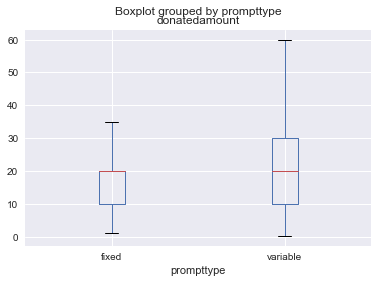

In [20]:
fig, ax = plt.subplots()
box = df.boxplot(column='donatedamount',by='prompttype',ax=ax, sym='', figsize=(15,5)) 
ax.margins(y=0.05) # this adds 5% of the range to the y axis
plt.show()

In [21]:
cols=['oneoffavgdonatedlast24m','oneoffdonationsl24m','everpledgeflag']
df[cols].groupby(by=df.prompttype).describe()

oneoffavgdonatedlast24m  oneoffdonationsl24m  everpledgeflag
prompttype                                                                    
fixed      count               185.000000           185.000000      185.000000
           mean                 19.988418             6.713514        0.059459
           std                  13.608554             3.889658        0.237124
           min                   0.000000             1.000000        0.000000
           25%                  10.000000             4.000000        0.000000
           50%                  18.333300             6.000000        0.000000
           75%                  26.666600             9.000000        0.000000
           max                  63.333300            17.000000        1.000000
variable   count              1573.000000          1573.000000     1573.000000
           mean                 18.310245             7.050858        0.062301
           std                  13.995836             4.048838        0.241779
           min                   0.000000             1.000000        0.000000
           25%                   9.375000             4.000000        0.000000
           50%                  15.000000             6.000000        0.000000
           75%                  25.000000            10.000000        0.000000
           max                 100.000000            19.000000        1.000000

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000000AC87710>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000000AD05E80>], dtype=object)

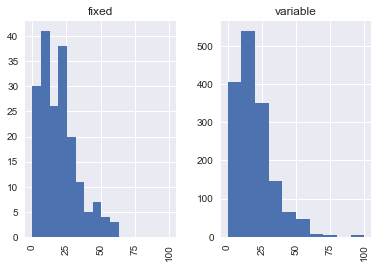

In [22]:
## checking stability 

# df['oneofflast24m_bin'] = pd.cut(df.oneoffavgdonatedlast24m,10)

# sns.factorplot(x='oneofflast24m_bin',data = df,row = 'prompttype',legend = True, kind='count', size =3, aspect = 3)

# sns.countplot(y="oneofflast24m_bin", hue="prompttype", data=df, palette="Greens_d",)
# sns.jointplot(x="donatedamount", y="oneoffavgdonatedlast24m", data=df, kind="kde",xlim=[0,50], ylim=[0,50]);
# sns.distplot(df.oneoffavgdonatedlast24m, bins=20, kde=False, );

df['oneoffavgdonatedlast24m'].hist(by=df['prompttype'], sharex = True)

Previously donated amounts are comparable in the fixed and variable samples.

In [ ]:
df.columns

In [23]:
# Creating a data frame of only the fixed sample.  
dfx = df[df.prompttype=='fixed']
dfv = df[df.prompttype=='variable']

# and a few lists;
campaign_features =['donatedamount','variableprompt1']
oneHist_features = ['oneoffavgdonatedlast24m','oneoffdonationsl24m','oneoffltv',
                    'lastoneoffamount', 'monthssincelastoneoff',] 
anyHist_features = ['alldonationsavgl24m', 'lifetimedonations',  'allltv', 'monthssincefirstdonation','monthssincelastdonation']
pct_features =  ['fixed_pct', 'var_pct'] 

### Check for normal distributions

In [13]:
dfx['donatedamount'].head()

1498    20.0000
1499    20.0000
1500    30.0000
1501    30.0000
1502    20.0000
Name: donatedamount, dtype: object

<function matplotlib.pyplot.show>

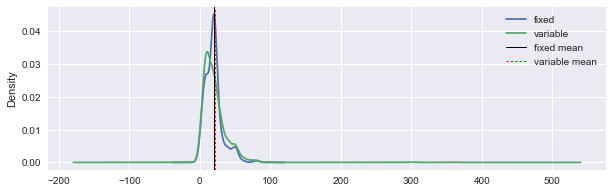

In [55]:
# Donated amount 
label1 = ['fixed','variable','fixed mean','variable mean']
ax = dfx['donatedamount'].plot(kind="density", figsize = (10,3)) # fixed
ax2= dfv['donatedamount'].plot(kind="density", figsize = (10,3)) # variable
plt.axvline(dfx['donatedamount'].mean(),     # Plot black line at fixed mean
           linewidth=1.0,
           color ='black')

plt.axvline(dfv['donatedamount'].mean(),     # Plot red line for variable mean
           linewidth=1.0,
           color ='red', 
           linestyle = ':')

ax.legend(labels=label1)

plt.legend = True
plt.show

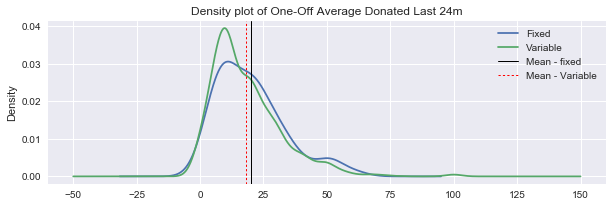

In [64]:
# donated amount last 24 months 
label2  = ['Fixed','Variable','Mean - fixed', 'Mean - Variable']
ax=dfx['oneoffavgdonatedlast24m'].plot(kind="density", figsize = (10,3)) # fixed
ax2=dfv['oneoffavgdonatedlast24m'].plot(kind="density", figsize = (10,3)) # variable
plt.axvline(dfx['oneoffavgdonatedlast24m'].mean(),     # Plot black line at fixed mean
           linewidth=1.0,
           color ='black')

plt.axvline(dfv['oneoffavgdonatedlast24m'].mean(),     # Plot red line for variable mean
           linewidth=1.0,
           color ='red', 
           linestyle = ':')
plt.title('Density plot of One-Off Average Donated Last 24m')
ax.legend(labels=label2)


Observations: 

None of the features are normally distributed, all are positively skewed because each of the features have a lower limit of 0 but an infinite upper limit.  This has the effect of pulling the mean towards the outliers and away from the median.  

**Donated amount** has two spikes around the £20 and £50 price points.

The Variable sample tended to have donated less on average than the fixed group.

### Correlation

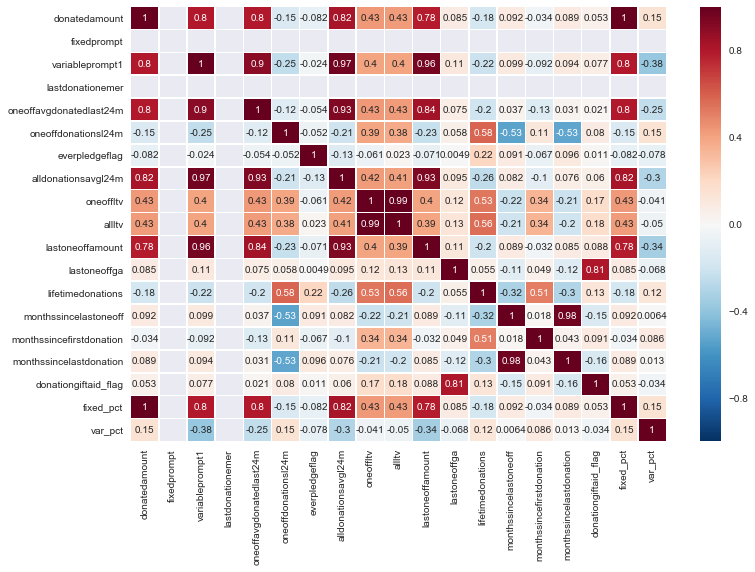

In [52]:
f,ax = plt.subplots(figsize=(12,8))
sns.heatmap(dfx.corr(), annot=True, linewidths=.5, ax=ax)

### Correlation observations: 

*Why isnt the correlation showing for fixed prompt?  *
  
cor(i,j) = cov(i,j)/[stdev(i)*stdev(j)]

If the values of the ith or jth variable do not vary, then the respective standard deviation will be zero and so will the denominator of the fraction. Thus, the correlation will be NaN.

The variable prompt has a strong correlation with the amount donated (0.8), in the previous lapsed analysis the correlation was much lower 0.33 - perhaps suggesting that the prompt strategy is better suited to active supporters.  

Of the features I could use to predict from, the following have the strongest correlation with donatedamount;  
(previous lapsed analysis correlation shown in brackets)

**alldonationsavgl24m**         0.82 (0.42)  
**oneoffavgdonatedlast24**       0.8 (0.15)  
**lastoneoffamount**            0.78 (0.46)  
**allltv**                      0.43 (0.27)  
**oneoffltv**                   0.43 (0.26)

The **"Months since"** variables continue to show a very weak correlation (less than 0.1) with donatedamount. 

In summary, the new active data is showing the same pattern of correlation as shown in the lapsed analysis, but relationships are stronger, which suggests that the model should perform better.  

nb anything that is a binary flag, isn't techinically a continous variable and therefore correlation isn't appropriate, see graphs below.  
nb The value of gift aid is not a predictor as it is 25% of the donated amount (i'll remove it from model builds).  

In [45]:
dfx = dfx.drop('giftaid', axis =1)

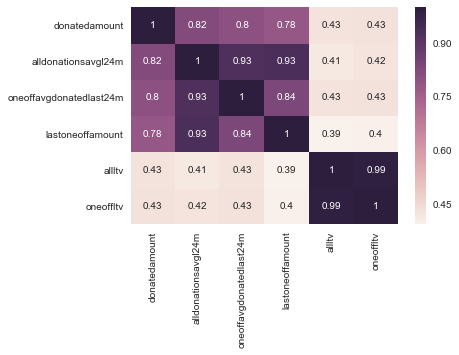

In [51]:
## checking for multicolinearity
predictors  = ['donatedamount', 'alldonationsavgl24m','oneoffavgdonatedlast24m', 'lastoneoffamount', 'allltv', 'oneoffltv' ]

sns.heatmap(dfx[predictors].corr(), annot = True)


"All LTV" and "one-off LTV" are highly correlated (0.99). They are equally correlated with donated amount - but I will keep **allltv**, so that this model/ prompt strategy can apply to non-cash givers.  

Alldonationsavgl24m, lastoneoffamount and oneoffavgdonatedlast24m are all highly correlated. Of the 3, **Alldonationsavgl24m** is best correlated with donatedamount and will be retained. Averaging a wider section of the supporters donations seems sensible too.

In [54]:
predictors  = ['donatedamount', 'alldonationsavgl24m','allltv' ]

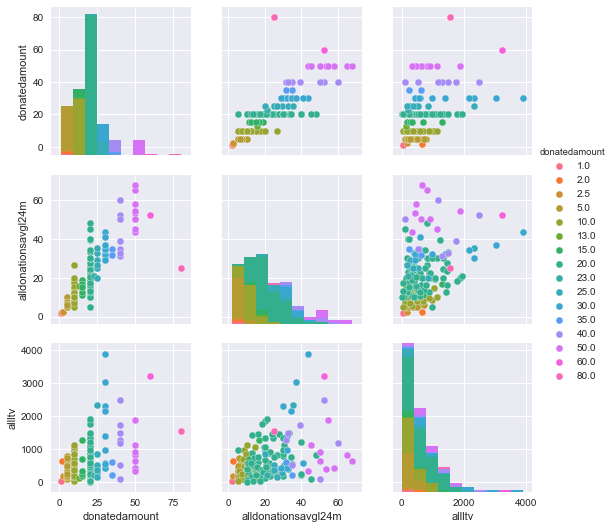

In [55]:
# Scatter plots visualise the correlation values above...
sns.pairplot(dfx, y_vars = predictors, x_vars =predictors ,hue='donatedamount')

## Analysing categorical variables 

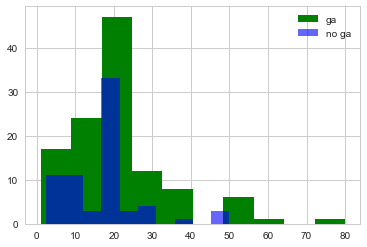

116 of 185 gave giftaid


In [68]:
# Histogram of donated amount grouped by giftaid_flag 
plt.hist(dfx['donatedamount'][df.lastoneoffga==1], label = 'ga', color = 'green')
plt.hist(dfx['donatedamount'][df.lastoneoffga==0], label ='no ga', alpha =0.6, color='blue') # alpha 0 = transparent, 1 =opaque.
plt.legend()
plt.show()
print(dfx.lastoneoffga.sum(),"of", len(dfx),"gave giftaid")

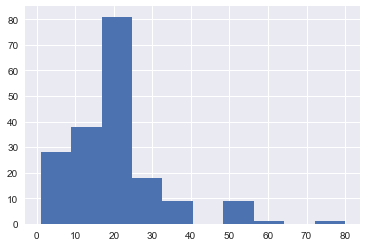

In [65]:
pd.crosstab(dfx.donatedamount,"")
dfx.donatedamount.hist()

** Last donation was to an emergency ** 

In [73]:
# looking at how lastdonationemer (categorical variables) affects the distribution of donated amount
# sns.factorplot(
#     x='lastdonationemer',
#     y='donatedamount',
#     data=dfx, 
#     kind='box', 
#     size =5)

# print('not emer', dfx['donatedamount'][(df.lastdonationemer ==0)].mean())
# print('emer', dfx['donatedamount'][(df.lastdonationemer ==1)].mean())

pd.crosstab(dfx.lastdonationemer,"")

lastdonationemer
1    185
Name: __dummy__, dtype: int64

THOSE THAT DONATED, ALL LAST GAVE TO AN EMERGENCY APPEAL! (mainly LB restriction, liberia?)

 ** Supporter has previously had a pledge/ regular gift ** 

no pledge 19.721264367816094
pledge 15.454545454545455
11 of 185 have previously had a pledge


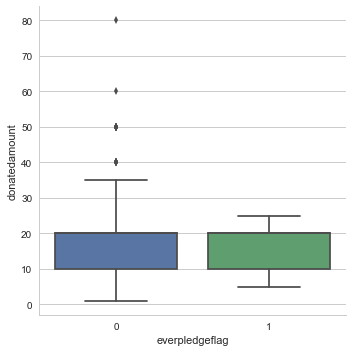

In [79]:
sns.factorplot(
    x='everpledgeflag',
    y='donatedamount',
    data=dfx, 
    kind='box', 
    size =5)

print('no pledge', dfx['donatedamount'][(df.everpledgeflag ==0)].mean())
print('pledge', dfx['donatedamount'][(df.everpledgeflag ==1)].mean())

print(dfx.everpledgeflag.sum(), "of", len(dfx),"have previously had a pledge")

Very few supporters in the sample have previously given pledge.  
The mean donated amount is higher where a supporter hasnt previously had a pledge, but this is likely to be due to the larger sample and greater likelihood of outliers.

In [133]:
# Running simple linear regression on everpledgeflag

import statsmodels.formula.api as smf

X = dfx[['everpledgeflag']]
y = dfx['donatedamount']

lm = smf.ols(formula='y ~ X', data=dfx).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.253
Date:                Thu, 31 Aug 2017   Prob (F-statistic):              0.264
Time:                        16:46:22   Log-Likelihood:                -725.18
No. Observations:                 185   AIC:                             1454.
Df Residuals:                     183   BIC:                             1461.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     19.7213      0.929     21.218      0.000        17.887    21.555
X             -4.2667      3.812     -1.119      0.264       -11.787     3.254
==============================================================================
Omnibus:                       62.565   Durbin-Watson:                   1.666
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              159.643
Skew:                           1.463   Prob(JB):                     2.16e-35
Kurtosis:                       6.485   Cond. No.                         4.24
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The Ordinary Least Squares model shows that everpledgeflag is insignificant when predicting the donated amount, as shown by the p-value 0.264 - significance threshold is 0.05.

### Creating dummies

In [80]:
# Taking the group from mosaic as I think mosaic (group and type) would create too many features for the sample size.
dfx['mosaicGroup'] = dfx['mosaic'].str[:1]

In [81]:
np.set_printoptions(suppress=True) # turning off scientific notation.

In [82]:
from sklearn import linear_model, feature_selection
lm =linear_model.LinearRegression()

def get_linear_model_metrics(X, y, algo):
    pvals = feature_selection.f_regression(X, y)[1]# get the pvalue of X given y. 
    algo.fit(X,y) # .fit() runs the linear regression function on X and y
    residuals = (y-algo.predict(X)).values

    print('P Values:',pvals) 
    print('Coefficients:', algo.coef_)
    print('y-intercept:', algo.intercept_)
    print('R-Squared:', algo.score(X,y))
    plt.figure()
    plt.hist(residuals, bins=np.ceil(np.sqrt(len(y))))
    # keep the model
    return algo

In [83]:
#REFINING MOSAIC GROUPS
pd.crosstab('',dfx.mosaicGroup)

mosaicGroup,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O
row_0,,,,,,,,,,,,,,,
,6,26,23,13,30,15,17,10,3,5,4,11,5,7,7


P Values: [ 0.31160129  0.0939479   0.6728686   0.16009274  0.94793717  0.98436341
  0.43310957  0.19436197  0.22841457  0.7467047   0.38838989  0.5154367
  0.37600412  0.14663377]
Coefficients: [ -6.04700855  -4.29951691  -9.7008547  -11.19444444  -8.11111111
  -8.36601307 -11.27777778 -17.44444444  -1.77777778 -10.27777778
 -11.41414141  -4.77777778 -12.34920635 -14.92063492]
y-intercept: 27.7777777778
R-Squared: 0.0922740375154


C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


Index(['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O'], dtype='object')


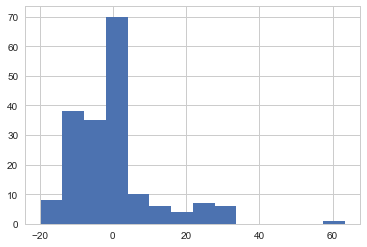

In [107]:
#is it because there are 7 observations with null mosaic that the coefficients aren't equal?
mosaic = pd.get_dummies(dfx.mosaicGroup)
mosaic = mosaic.ix[:,1:15] # dropping dummy A 

y= dfx.donatedamount

get_linear_model_metrics(mosaic, y, lm)  #mosaic[[1,4, 5,7,11]]
print 
print (mosaic.columns)

All P-values are greater than 0.05 and therefore not significant. Mosaic group "C" has the lowest p-value of 0.09, so I will test this in the model.

In [110]:
## Appending Mosaic group C 
dfx = pd.concat([dfx, mosaic[[1]]], axis=1)

In [112]:
dfx.head()

,activitycode,prompttype,mosaic,audienceprofile2016,donatedamount,fixedprompt,variableprompt1,lastdonationemer,oneoffavgdonatedlast24m,oneoffdonationsl24m,...,lastoneoffga,lifetimedonations,monthssincelastoneoff,monthssincefirstdonation,monthssincelastdonation,donationgiftaid_flag,fixed_pct,var_pct,mosaicGroup,C
1498,KA64,fixed,B05,Wealthy Wellwishers,20.0,20.0,15.0,1,20.0000,5,...,0,20,8,129,8,0,1.0,1.333333,B,0
1499,KA64,fixed,E19,Not in target,20.0,20.0,25.0,1,22.3333,4,...,1,9,9,70,0,1,1.0,0.800000,E,0
1500,KA64,fixed,J42,Not in target,30.0,20.0,35.0,1,31.6666,7,...,0,34,6,220,6,0,1.5,0.857143,J,0
1501,KA64,fixed,C13,Rapid Responders,30.0,20.0,30.0,1,30.0000,8,...,1,103,2,223,2,1,1.5,1.000000,C,1
1502,KA64,fixed,C13,Rapid Responders,20.0,20.0,30.0,1,26.0000,6,...,1,33,2,149,2,1,1.0,0.666667,C,1


In [113]:
#REFINING AUDIENCE PROFILES 
audience = pd.get_dummies(dfx.audienceprofile2016) 
audience.head()

,Mindful Mums,Not in target,Rapid Responders,Upwardly Urban,Wealthy Wellwishers
1498,0,0,0,0,1
1499,0,1,0,0,0
1500,0,1,0,0,0
1501,0,0,1,0,0
1502,0,0,1,0,0


In [114]:
pd.crosstab(dfx.audienceprofile2016,'')

audienceprofile2016
Mindful Mums            4
Not in target          70
Rapid Responders       45
Upwardly Urban         28
Wealthy Wellwishers    35
Name: __dummy__, dtype: int64

P Values: [ 0.25193568  0.11053077  0.54917526  0.0659578   0.22990717]
Coefficients: [-10.83333333  -5.71190476  -4.82222222   0.05952381  -1.61904762]
y-intercept: 23.3333333333
R-Squared: 0.0406853784069


C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

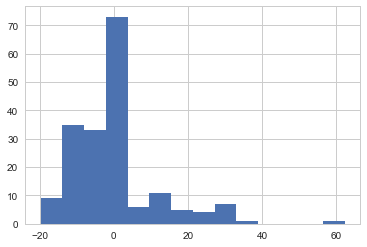

In [116]:
get_linear_model_metrics(audience[[0,1,2,3,4]], y, lm)

Upwardly urban has a p-value of 0.06, which is the only audience category close to the 0.05 threshold.  The coefficient (in relation to the other audience profiles doesn't seem very help though as it hovers close to zero;  0.05952381.

P Values: [ 0.0659578]
Coefficients: [ 4.62534122]
y-intercept: 18.7675159236
R-Squared: 0.0183545537229


C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


<function print>

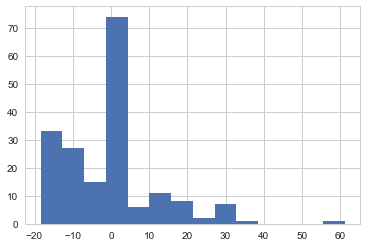

In [120]:
# droped audience dummies where the p value is >0.05
get_linear_model_metrics(audience[[3]], y, lm)
print 

In [127]:
audience[[3]].head(1)

,Upwardly Urban
1498,0


In [124]:
## appending significant audiences to the main df
dfx = pd.concat([dfx, audience[[3]]], axis=1)

The following charts confirm the coefficients:

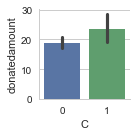

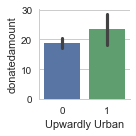

In [126]:
# plot mean donated amount by each dummy category to understand it's effect
dummies = ['C', 'Upwardly Urban']

for c in dummies:
    sns.factorplot(
        x=c,
        y='donatedamount',
        data=dfx, 
        kind='bar', 
        size =2)

In [125]:
dfx.columns

Index(['activitycode', 'prompttype', 'mosaic', 'audienceprofile2016',
       'donatedamount', 'fixedprompt', 'variableprompt1', 'lastdonationemer',
       'oneoffavgdonatedlast24m', 'oneoffdonationsl24m', 'everpledgeflag',
       'alldonationsavgl24m', 'oneoffltv', 'allltv', 'lastoneoffamount',
       'lastoneoffga', 'lifetimedonations', 'monthssincelastoneoff',
       'monthssincefirstdonation', 'monthssincelastdonation',
       'donationgiftaid_flag', 'fixed_pct', 'var_pct', 'mosaicGroup', 'C',
       'Upwardly Urban'],
      dtype='object')

In [137]:
##saving to csv a clean file that can be used for model builds.
cols_to_keep = ['donatedamount','alldonationsavgl24m', 'allltv',
                'mosaicGroup', 'C','audienceprofile2016', 'Upwardly Urban']

df_clean= dfx[cols_to_keep]


In [138]:
df_clean.to_csv('//unicef-data/Data/Data/Fund/Public/Internal insight/Analysis/2017 Projects/K037 Cash Prompt Optimisation/3 Working files/K037_fixed_cash_model_inputv2.csv'
                , sep=',')

In [12]:
#HAVEN'T RAN THIS FOR VERSION 2 
# Updated 19/05/2017: commented out dummy variables as these aren't required for decision trees/ random forest.
## Saving a csv a copy of the cleaned file but including outliers for the random forest training.
df['mosaicGroup'] = df['mosaic'].str[:1]
# mosaic = pd.get_dummies(df.mosaicGroup, prefix = 'mosaic')
# mosaic.columns
df_cols =['donatedamount', 'audienceprofile2016', 'fixedprompt','oneoffavgdonatedlast24m','oneoffdonationsl24m', 
             'everpledgeflag','lastdonationemer', 'alldonationsavgl24m', 'oneoffltv', 'allltv', 'lastoneoffamount','lastoneoffga', 
             'lifetimedonations', 'monthssincelastoneoff','monthssincefirstdonation', 'monthssincelastdonation',
             'outlier_flag','mosaicGroup']

df_final = df[df_cols]#.join(mosaic[['mosaic_A', 'mosaic_B', 'mosaic_C', 'mosaic_D', 'mosaic_E', 'mosaic_F',
#                                     'mosaic_G', 'mosaic_H','mosaic_I', 'mosaic_J', 'mosaic_K', 'mosaic_L',
#                                     'mosaic_M', 'mosaic_N']]) # left out 'mosaic_O'

df_final.to_csv('//unicef-data/Data/Data/Fund/Public/Internal insight/Analysis/2017 Projects/K037 Cash Prompt Optimisation/3 Working files/K037_fixed_cash_model_input_nodummiesv2.csv'
                , sep=',')

In [13]:
df_final.head().T

,0,1,2,3,4
donatedamount,10,63,10,20,50
audienceprofile2016,Upwardly Urban,Not in target,Not in target,Rapid Responders,Unclassified
fixedprompt,20,20,20,20,20
oneoffavgdonatedlast24m,8.3333,25,0,30,30
oneoffdonationsl24m,4,3,1,2,4
everpledgeflag,0,0,1,0,0
lastdonationemer,1,0,0,1,1
alldonationsavgl24m,8.75,26.6666,10.2941,25,35
oneoffltv,64,700,15,517,245
allltv,64,700,215,517,245
